# Data extraction and pre-processing

We will start by importing the necessary libraries.

In [15]:
import numpy as np
import time
import pandas as pd
from tqdm import tqdm # To visualize a loading bar of the epochs
import matplotlib.pyplot as plt

We also proceed to seed the randomness to ensure the reproducibility of the results.

In [16]:
np.random.seed(0)

Note about files: This colab assumes that the user's google drive was mounted through the UI (Button at the top-left, under the file manager) and that the data is accessible at the path provided below. Please modify it to match the path to the data folder on your drive. To make it easier, you can right click that folder and press "copy path" after mounting.

In [17]:
path_to_data = "/content/drive/MyDrive/Courses/ECSE552/A1/data"

The next step is now to extract the data from the provided files as well as the dimensions of the inputs & outputs.

In [18]:
# Training Data & validation data
X_train = pd.read_csv(path_to_data + '/training_set.csv', header=None).values
y_train = pd.read_csv(path_to_data + '/training_labels_bin.csv', header=None).values
X_val = pd.read_csv(path_to_data + '/validation_set.csv', header=None).values
y_val = pd.read_csv(path_to_data + '/validation_labels_bin.csv', header=None).values

# Extract dimensions
N_train = len(X_train) # Number of training inputs
N_val = len(X_val) # Number of validation inputs
D = X_train.shape[1] # Number of features
n_out = y_train.shape[1] # Number of labels

We now proceed to shuffle the input data to avoid any preset ordering of the datapoints.

In [19]:
# Generate a random permutation from 0 up to N-1 and use it to shuffle
idx_train = np.random.permutation(N_train)
idx_val = np.random.permutation(N_val)
X_train, y_train = X_train[idx_train], y_train[idx_train]
X_val, y_val = X_val[idx_val], y_val[idx_val]

Before proceeding to the MLP implementation, we can visualize the distributions of the different input features, as well as the distribution of the labels. As a first step, we can visualize the proportions of each class for each of the three output labels.

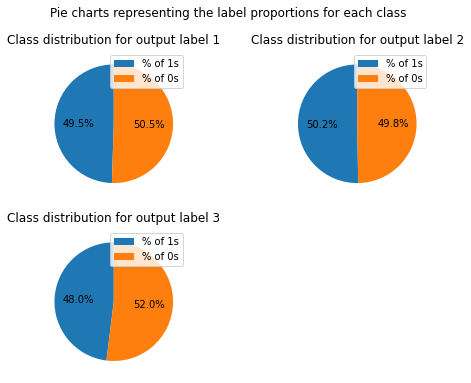

In [20]:
# Compute a 1D array with 3 entries, each representing the number of 1's for a respective class
num_ones = np.sum(y_train, axis=0)

# Divide each of the sums by the number of inputs to get the proportions of 1's for each class
num_ones = (num_ones / N_train)

# For each of the labels, make a pie chart representing the proportion of 1's VS that of 0's
fig = plt.figure(figsize=(8, 6)) # To plot multiple charts
fig.suptitle('Pie charts representing the label proportions for each class')
for i in range(3):
  ax1 = fig.add_subplot(221+i) # 22 means 2x2, while the third digit represents the figure number
  plt.pie(np.vstack((num_ones, 1-num_ones))[:,i], startangle=90, autopct='%1.1f%%')
  plt.legend(['% of 1s', '% of 0s'], loc="best")
  plt.title(f"Class distribution for output label {i+1}")

# Save the figure
plt.savefig("distribution.png")

As can be seen above, the 3 classes are very balanced (Almost 50/50). Even though we will not perform it in this report, it is to be mentioned that ROC curve analysis fits this problem very well.

TODO: Analyze the distribution of the 354 input features

# MLP implementation

The next step is now to implement the sigmoid activation function that will be used for both the hidden and output activations using the formula:
$$ \sigma(a) = \frac{1}{1+e^{-a}}$$
However, since we'll be operating on batches of 1 datapoint, we can write an equivalent of the above version which takes in a vector (Representing either the output of the previous activation layer or the input vector) and applies the element-wise operation described above to every individual element.

In [21]:
# Takes as input a vector (Also works on matrices if batch has more than 1 element)
# Applies the sigmoid function to every vector element
def sigmoid(a):
  return 1 / (1 + np.exp(-a))

We can now also define the requested error function (Here SSE) in the function below for later use:

In [22]:
# Takes as input the 3 outputs of the NN as well as the 3 expected labels
# output is a 3-entry 1D array, where each entry is a respective output of the NN
# expected is a 3-entry 1D array too, where each entry is the true label of the corresponding slot in output
# It returns the sum of the squared errors over the 3 outputs of the NN
def compute_sse(output, expected):
  return np.sum(np.square(output-expected))

The next step is now to define the neural network architecture. While the starter code provides a simple lightweight template which basically reduces the MLP to a for-loop, we will opt to reuse some parts of the provided code by refactoring it into a proper object-oriented MLP class for better understandability and scalability. But before defining the MLP class, we can start by defining a class to represent a hidden layer, which will contain the weights and biases of that layer.

It is to be noted that the weights and biases will be sampled from the distribution
$$N(0, \frac{2}{n_{in} + n_{out}})$$
in order to avoid gradient explosions during the forward pass, basically adapting to the number of inputs & outputs of the layer in question.

In [23]:
# Class that represents a single hidden MLP layer
class HiddenLayer:

  def __init__(self, n_in, n_out):
    self.W = np.random.normal(0, 2 / (n_in + n_out), (n_in, n_out)) # Weights
    self.b = np.random.normal(0, 2 / (n_in + n_out), (1, n_out)) # Biases
    self.g_W = None # Gradient of the weights
    self.g_b = None # Gradient of the biases
    self.input = None # The input of the layer, saved during the forward pass and reused during the backpropagation

  # The forward pass function consists of performing the affine transformation using the weights before applying sigmoid
  # Takes as input the activated output of the previous layer
  def forward_pass(self, x):
    self.input = x
    debug = sigmoid((x @ self.W) + self.b)
    return debug

  # Function to be implemented later
  def backward_pass(self, g_next):
    pass

The next step is now to define a class which will represent the output layer. Since that class is basically the same as a hidden layer (Because we are using sigmoid as the output activation) with the only difference being the backpropagation gradient formulas (Takes the derivative with respect to the loss function directly), we will start by extending the hidden layer class and then later override the gradient backpropagation formulas when the time comes to define them.

In [24]:
class OutputLayer(HiddenLayer):

  # Only takes n_in as input since n_out is always 3 here
  def __init__(self, n_in):
    super().__init__(n_in, 3) # Call the superclass constructor with n_out = 3
    self.y_hat = None # To store the last outputted y_hat

  # The forward pass function consists of performing the affine transformation using the weights before applying sigmoid
  # Saves its output to be used during the backward pass
  # Takes as input the activated output of the previous layer
  def forward_pass(self, x):
    self.input = x
    self.y_hat = sigmoid((x @ self.W) + self.b)
    return self.y_hat

  # Function to be implemented later
  def backward_pass(self, y):
    pass

We can now move on to implementing the forward & backward pass functions of the output layer. Assuming the 3 outputs of the MLP are $\hat{y_1}$, $\hat{y_2}$, and $\hat{y_3}$ respectively, we can define $\vec{\hat{y}}$ = [ $\hat{y_1}$, $\hat{y_2}$, $\hat{y_3}$]. The loss function for 1 input datapoint becomes:
$$L(\vec{y}, \vec{\hat{y}}) = (\hat{y_1}-y_1)^2 + (\hat{y_2}-y_2)^2 + (\hat{y_3}-y_3)^2$$
Re-writing $(\hat{y_i}-y_i)^2$ as $L_i$, we get that:
$$L(\vec{y}, \vec{\hat{y}}) = \Sigma_{i=1}^3 L_i$$
Consequently: $$\frac{\partial{L}}{\partial{\hat{y_i}}} = \frac{\partial{L_i}}{\partial{\hat{y_i}}} = 2(\hat{y_i}-y_i) \tag{1}$$ 
This means that, at the output layer, we get:
$$\frac{\partial{L}}{\partial{{w_{i,j}}^{o}}} = \Sigma_{k=1}^{3} \frac{\partial{L_k}}{\partial{\hat{y_k}}}.\frac{\partial{\hat{y}_{k}}}{\partial{{w_{i,k}}^o}} = \frac{\partial{L_j}}{\partial{\hat{y_j}}}.\frac{\partial{\hat{y}_{j}}}{\partial{{w_{i,j}}^o}}$$
Furthermore, assuming $o_k$ is the pre-activated output, we know that:
$$\hat{y_j} = \sigma{(o_j)}$$
We can thus incorporate $o_k$ into the chain rule to get:
$$\frac{\partial{L}}{\partial{{w_{i,j}}^{o}}} = \frac{\partial{L_j}}{\partial{\hat{y_j}}}.\frac{\partial{\hat{y}_{j}}}{\partial{o_j}}.\frac{\partial{o_j}}{\partial{{w_{i,j}}^o}} \tag{2}$$
We can now calculate:
$$
\begin{split}
\frac{\partial{\hat{y}_{j}}}{\partial{o_j}} & = \frac{\partial}{\partial{o_j}}(\frac{1}{1+e^{-o_j}}) \\[1ex]
    & =  -\frac{-e^{-o_j}}{{(1+e^{-o_j})}^2} \\[1ex]
    & = \frac{e^{-o_j}}{{1+e^{-o_j}}}.\frac{1}{{1+e^{-o_j}}} \\[1ex]
    & = (1-\frac{1}{{1+e^{-o_j}}}).\frac{1}{{1+e^{-o_j}}}  \\[1ex]
    & = (1-\sigma{(o_j)}).\sigma{(o_j)} \\[1ex]
    & = (1-\hat{y_j})\hat{y_j} \\[1ex]
\end{split}
\tag{3}$$
Finally, assuming ${h_i}^2$ is the ith activated hidden unit of the 2nd hidden layer (that comes before the output layer), we know that:
$$\frac{\partial{o_j}}{\partial{{w_{i,j}}^o}} = {h_i}^2 \tag{4}$$ 
Plugging (1), (3), and (4) into 2, we get the following:
$$
\begin{split}
\frac{\partial{L}}{\partial{{w_{i,j}}^{o}}} & = \frac{\partial{L_j}}{\partial{\hat{y_j}}}.\frac{\partial{\hat{y}_{j}}}{\partial{o_j}}.\frac{\partial{o_j}}{\partial{{w_{i,j}}^o}}  \\[1ex]
    & = 2(\hat{y}_j - y_j).(1 - \hat{y}_j)\hat{y}_j.{h_i}^2 \\[1ex]
\end{split}
$$
The final task is thus to extend the above gradient the matrix of output layer weights $W^o$ by inspecting the dimensions of the terms. Assuming $\hat{y}$ and $y$ are both horizontal 1x3 vectors (Just convention), and that $\vec{h}^2$ is also horizontal with size kx3, we get that:
$$
\begin{split}
\frac{\partial{L}}{\partial{{W}^{o}}} & = \vec{h^2}^T.((\vec{\hat{y}} - \vec{y})\odot (1-\vec{\hat{y}}) \odot \vec{\hat{y}}).2 \\[1ex]
\end{split}
$$
As a check, the above's dimensions reduces to (kx1).(1x3) = kx3, which is exactly the size of $W^o$, validating that this is indeed the jacobian of said matrix.

As to the gradient with respect to the bias terms, it is equal to the gradient with respect to the pre-activated units since $\frac{\partial{o_j}}{\partial{{b_j}^o}} = 1$. Consequently,
$$
\frac{\partial{L}}{\partial{{\vec{b}^{o}}}} = \frac{\partial{L}}{\partial{\vec{o}}} = ((\vec{\hat{y}} - \vec{y})\odot (1-\vec{\hat{y}}) \odot \vec{\hat{y}}).2
$$

Finally, the output layer consists of both the affine transformation as well as the output activation. Because the formulas of previous layers will reuse the derivative of the loss function with respect to the pre-activated input layer which is $\vec{a^{2}}$, the `backward_pass` function will return that gradient after computing and storing the gradients with respect to the weights and the bias. Consequently, `backward_pass` needs to return $\frac{\partial{L}}{\partial{\vec{a^2}}}$. In order to compute the above derivative, we will start by finding the correponding derivative with respect to one element of the second hidden layer ${a_i}^2$. Assuming $k_o$ is the width of the output layer, we get that:
$$\frac{\partial{L}}{\partial{{a_i}^2}} = (Σ_{k=1}^{k_o} \frac{\partial{L}}{\partial{o_k}}.\frac{\partial{o_k}}{\partial{h_i^2}}).\frac{\partial{h_i^2}}{\partial{a_i^2}} \tag{5}$$
Since the output and hidden layer activations are the same, we know from (3) that:
$$\frac{\partial{h_i^{2}}}{\partial{a_i^{2}}} = h_i^{2}(1-h_i^{2}) \tag{6}$$

Finally, due to the affine transformation that related the terms, we know that: 
$$\frac{\partial{o_k}}{\partial{h_i^{2}}} = {w_{i,k}}^o \tag{7}$$

Plugging (6) and (7) into (5), we get:
$$\frac{\partial{L}}{\partial{{a_i}^2}} = (Σ_{k=1}^{k_o} \frac{\partial{L}}{\partial{o_k}}.{w_{i,k}}^o) . h_i^{2}(1-h_i^{2})$$

Again, converting to matrix form, and assuming the width of hidden layer 2 is $k_{2}$ we would like to compute:
$$
\frac{\partial{L}}{\partial{\vec{a^{2}}}} = [\frac{\partial{L}}{\partial{{a_1}^{2}}}, \frac{\partial{L}}{\partial{{a_2}^{2}}}, ..., \frac{\partial{L}}{\partial{{a_{k_{2}}}^{2}}}]
$$
which by our convention is a 1 x $k_{2}$ horizontal vector. Using dimensionality analysis, and assuming that
$$\frac{\partial{L}}{\partial{\vec{o}}} = [\frac{\partial{L}}{\partial{o_1}}, \frac{\partial{L}}{\partial{o_2}}, ..., \frac{\partial{L}}{\partial{o_{k_o}}}]$$
is a horizontal vector, we get:
$$\frac{\partial{L}}{\partial{\vec{a^{2}}}} = (\frac{\partial{L}}{\partial{\vec{o}}}.{W^o}^T)⊙\vec{h^{2}}⊙(1-\vec{h^{2}})$$
which outputs a dimension of (1 x $k_{o}$).($k_{o}$ x $k_{2}$) = (1 x $k_{2}$), which is the desired dimension.

In [25]:
# The backward pass consists of using the formula above to find the gradient with respect to the weights
# Takes as input the labels of the input used during the forward pass (1x3 vector)
def backward_pass(self, y):
  g_o = 2*(self.y_hat - y)*(1-self.y_hat)*self.y_hat # Compute the gradient with respect to its pre-activated layer to return to previous layer
  self.g_W = self.input.T @ g_o # self.input is the activated input of the previous layer during the last forward pass
  self.g_b = g_o # The gradient with respect to the bias multiplies grad_o's elements by 1's
  g_a = (g_o @ self.W.T) * self.input * (1 - self.input) # For the previous layer's gradient calculations, as proven in the final part above
  return g_a
  
OutputLayer.backward_pass = backward_pass

We now proceed to prove the gradient formulas for an arbitrary hidden layer using the results derived for the output layer. For both layers 1 and 2 of the MLP, the formula for finding the gradient with respect to a weight of an arbitrary layer l $∈$ {1, 2} (Since we only have 2 hidden layers) is as follows:
$$\frac{\partial{L}}{\partial{{w_{i,j}}^{l}}} = \frac{\partial{L}}{\partial{{a_j}^l}}.\frac{\partial{{a_j}^l}}{\partial{{w_{i,j}}^{l}}}$$
under the assumption that ${a_j}^l$ is the $j^{th}$ pre-activated unit of layer l, and weight ${w_{i,j}}^l$ connects activated unit ${h_i}^{l-1}$ to pre-activated unit ${a_j}^l$.

Since $\frac{\partial{L}}{\partial{{a_j}^l}}$ is given in the function's input (Passed from the return value of `backward_pass` of the following layer), we thus only need to multiply that by:
$$\frac{\partial{{a_j}^l}}{\partial{{w_{i,j}}^{l}}} = {h_i}^{l-1}$$
or, in other words, by the corresponding input to the layer during the forward pass, justifying why we saved that input in memory as the instance variable `input`. The final result of the gradient with respect to a single weight is thus:
$$\frac{\partial{L}}{\partial{{w_{i,j}}^{l}}} = \frac{\partial{L}}{\partial{{a_j}^l}}.{h_i}^{l-1}$$
Converting the above to matrix form (Derivative with respect to every weight, or in other words the jacobian with respect to the weights), and assuming that the derivative with respect to every pre-activated unit of the next layer that is passed as input to our `backward_pass` function is the horizontal vector
$$\frac{\partial{L}}{\partial{\vec{a^l}}} = [\frac{\partial{L}}{\partial{{a_1}^l}}, \frac{\partial{L}}{\partial{{a_2}^l}}, ..., \frac{\partial{L}}{\partial{{a_{k_l}}^l}}]$$
where $k_l$ is the width of layer l, we get that:
$$\frac{\partial{L}}{\partial{W^l}} = \vec{h^{l-1}}^T.\frac{\partial{L}}{\partial{\vec{a^l}}}$$
As a sanity check, we can again use dimensionality analysis to check that the result is of size $(k_{l-1} × 1).(1 × k_l) = k_{l-1} × k_l$, which is the same dimension as the matrix $W^l$, validating the correctness of the jacobian.

Furthermore, as in the case of the output layer, assuming that ${b_j}^l$ is the bias term that leads to ${a_j}^l$, we know that:
$$\frac{\partial{{a_j}^l}}{\partial{{b_j}^{l}}} = 1$$
Consequently, we get that:
$$\frac{\partial{L}}{\partial{\vec{b^l}}} = \frac{\partial{L}}{\partial{\vec{a^l}}}$$
Finally, the layer should return the derivative with respect to its pre-activated output for the previous layer to use as its input. Consequently, we can start by computing the derivative with respect to a single pre-activated unit $a_j^{l-1} $ for simplicity, before expanding it to matrix form.

Using the chain rule, we can again write:
$$
\frac{\partial{L}}{\partial{a_j^{l-1}}} =  (Σ_{k=1}^{k_l} \frac{\partial{L}}{\partial{a_k^{l}}}.\frac{\partial{a_k^{l}}}{\partial{h_j^{l-1}}}).\frac{\partial{h_j^{l-1}}}{\partial{a_j^{l-1}}} \tag{8}
$$
Please note that the sum is necessary because all pre-activated units of the next layer each depend on every single activated unit of the previous layer in an MLP. Since the hidden layer & output activations are the same, we can use the equation proven in (3) without loss of generality to infer the following formula:

$$\frac{\partial{h_j^{l-1}}}{\partial{a_j^{l-1}}} = h_j^{l-1}(1-h_j^{l-1}) \tag{9}$$

Finally, due to the affine transformation that related the terms, we know that: 
$$\frac{\partial{a_k^{l}}}{\partial{h_j^{l-1}}} = {w_{j,k}}^l \tag{10}$$

Plugging (9) and (10) into (8), we get:
$$
\frac{\partial{L}}{\partial{a_j^{l-1}}} =  (Σ_{k=1}^{k_l} \frac{\partial{L}}{\partial{a_k^{l}}}.{w_{j,k}}^l).(h_j^{l-1})(1-h_j^{l-1})
$$

Again, converting to matrix form, we would like to compute:
$$
\frac{\partial{L}}{\partial{\vec{a^{l-1}}}} = [\frac{\partial{L}}{\partial{{a_1}^{l-1}}}, \frac{\partial{L}}{\partial{{a_2}^{l-1}}}, ..., \frac{\partial{L}}{\partial{{a_{k_{l-1}}}^{l-1}}}]
$$
which by our convention is a 1 x $k_{l-1}$ horizontal vector. Using dimensionality analysis, we get:
$$\frac{\partial{L}}{\partial{\vec{a^{l-1}}}} = (\frac{\partial{L}}{\partial{\vec{a^l}}}.{W^l}^T)⊙\vec{h^{l-1}}⊙(1-\vec{h^{l-1}})$$
which outputs a dimension of (1 x $k_{l}$).($k_{l}$ x $k_{l-1}$) = (1 x $k_{l-1}$), which is the desired dimension.

In [26]:
# Takes as input the gradient with respect to the pre-activated units of the next layer
# Computes and stores the gradient with respect to its weights and biases
# Returns the gradient with respect to the pre-activated units of its layer for the previous layer to use
def backward_pass(self, g_a_next):
  g_a = (g_a_next @ self.W.T) * self.input * (1-self.input) # Gradient with respect to the layer's pre-activated input
  self.g_W = self.input.T @ g_a_next # Compute the jacobian wrt the weights according to the formula proven above
  self.g_b = g_a_next # Compute the gradient with respect to the biases according to the formula proven above
  return g_a # Return the gradient with respect to the pre-activated units for the previous layer to use

HiddenLayer.backward_pass = backward_pass

Now that we have completed both types of layers, we can move on to defining the MLP class that will hold and coordinate them:

In [27]:
class MLP:
  
  # Initializes the MLP with the following parameters:
  # - D: The dimension of the inputs to the MLP (Number of features)
  # - widths: A list of 2 elements holding the respective widths of the 2 hidden layers
  # - threshold: The minimum threshold of the validation error before stopping training
  # - test_interval: The number of epochs before computing the validation error
  # - max_epoch: Max number of epochs before stopping
  # - eta: Initial learning rate
  # - gamma: Multiplier for the learning rate
  # - stepsize: Number of epochs before changing the learning rate
  def __init__(self, D, widths):
    
    # List of layers, initialized & ordered from input to output
    self.layers = []
    self.layers.append(HiddenLayer(D, widths[0]))
    self.layers.append(HiddenLayer(widths[0], widths[1]))
    self.layers.append(OutputLayer(widths[1]))

  # Forward pass for the whole class, iterates through the layers given a sample
  # Returns the output of the output layer
  def forward_pass(self, input):
    for layer in self.layers:
      input = layer.forward_pass(input)
    return input

  # Backward pass for the whole class, iterates through the layers from last to first given the output of the NNet
  def backward_pass(self, label):
    for layer in self.layers[::-1]:
      label = layer.backward_pass(label)

  # Function that updates the parameters of every layer after a forward & backward pass pair
  # Takes the effective learning rate as input at the time of the update
  def update_parameters(self, eta):
    for layer in self.layers:
      layer.W = layer.W - eta * layer.g_W
      layer.b = layer.b - eta * layer.g_b
      

  # Train function, takes in the full training & validation datasets and trains the neural network using those
  # It is inspired from the provided starter code and prints the validation error through epochs to the console
  def train(self, X_train, y_train, X_val, y_val, threshold=0.08, test_interval=10, max_epoch=2000, eta=0.01, gamma=0.5, stepsize=200):
    
    # To store the MSEs on the training & validation MSEs through epochs
    train_mses = []
    val_mses = []

    # Iterate through epochs
    for epoch in tqdm(range(0, max_epoch)):
      
      # Re-shuffle the data for the epoch
      order = np.random.permutation(N_train)
      
      # To accumulate the SSE's of the whole epoch and plot the average
      sse = 0

      # Iterate through the shuffled datapoints (Iteration loop)
      for n in range(0, N_train):
          
          # Extract a datapoint (Batch size is 1) as a numpy array
          idx = order[n]
          x_in = np.array(X_train[idx]).reshape((1, D))
          y = np.array(y_train[idx]).reshape((1, n_out))

          # Do the forward pass using the input point and retrieve the output y hat vector
          y_hat = self.forward_pass(x_in)
      
          # Compute the squared error for the current iteration
          squared_error = compute_sse(y_hat, y)

          # Perform a backward pass using the output labels
          self.backward_pass(y)

          # Update the weights and biases
          self.update_parameters(eta)

          # Accumulate the error to plot it every epoch
          sse += squared_error

      # At the end of the epoch, average over the number of points
      train_mse = sse/N_train

      # Append to array
      train_mses.append((epoch, train_mse))

      # Check if should compute the validation error
      if epoch % test_interval == 0: 
          
          # Compute the validation error on the full batch
          # Note: Forward pass modifies the inner state of the model, but it's fine because it will get overriden again during the next training forward pass
          val_sse = compute_sse(self.forward_pass(X_val), y_val)
          val_mse = val_sse / N_val

          # Append to array
          val_mses.append((epoch, val_mse))

          # If termination condition is satisfied, exit
          if val_mse < threshold:
              print(f'Validation error lower than {threshold}, terminating.')
              break

      # Check if should increase the learning rate
      if epoch % stepsize == 0 and epoch != 0:
          eta = eta*gamma
          print(f'Changed learning rate to lr={eta}')

    return train_mses, val_mses

We can now train the MLP using 2 hidden layers both having width 10, with the following hyperparameters:
- threshold = 0.08
- test_interval = 10
- max_epoch = 3000
- eta = 0.01
- gamma = 0.1
- stepsize = 200

In [28]:
mlp1 = MLP(D, [10, 10])
train_mses, val_mses = mlp1.train(X_train, y_train, X_val, y_val)

 10%|█         | 201/2000 [03:28<35:23,  1.18s/it]

Changed learning rate to lr=0.005


 14%|█▎        | 270/2000 [04:37<29:38,  1.03s/it]

Validation error lower than 0.08, terminating.


The resulting plot for training & validation loss as a function of epochs can be found below:

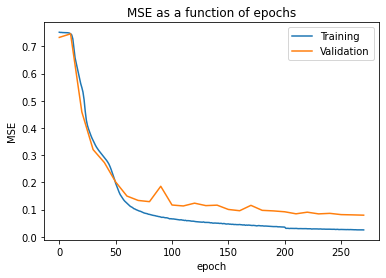

In [29]:
plt.plot(*zip(*train_mses), label="Training")
plt.plot(*zip(*val_mses), label="Validation")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("MSE as a function of epochs")
plt.legend(loc="best")
plt.savefig("error.png")

Both errors seem to be decreasing on average, with the slight fluctuations due to using online (1-point) stochastic gradient descent.